In [1]:
from langchain_community.utilities import SQLDatabase
import pymysql
from langchain_community.utilities import SQLDatabase
from typing import Any
from langchain_core.runnables import RunnableWithFallbacks, RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

In [2]:
import getpass
import os

from dotenv import load_dotenv

load_dotenv()

def set_env(key: str):
  if key not in os.environ:
    os.environ[key]=getpass.getpass(f"{key}:")
set_env("GROQ_API_KEY")
set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="llm-agent-sql-2"

In [3]:
username = "root"
password = "jagan2911"
host = 'localhost'
database = 'jagandb'

In [4]:
db = SQLDatabase.from_uri(f"mysql+pymysql://{username}:{password}@{host}/{database}",sample_rows_in_table_info = 3)
print(db.dialect)
print(db.get_usable_table_names())

mysql
['employee']


In [5]:
from pydantic import BaseModel, Field
from typing import List, Any, Dict

In [6]:
class Query(BaseModel):
    statement: str = Field(description="The SQL query to execute")
    reasoning: str = Field(description="Reasoning behind the query")
    is_valid: bool = Field(True,description="Indicates if the statement is valid")
    result: str = Field("",description="query result")
    error: str = Field("",description="Error message if applicable")
    
    @property
    def info(self) -> str:
        return (f"SQL query:\n{self.statement}\n\n"
    f"The reasoning you used to create that query was:\n{self.reasoning}\n\n"
    f"And this is the result you get:\n{self.result}")
    @property
    def error_info(self) -> str:
        return(f"Wrong SQL query:\n{self.statement}\n\n"
    f"The reasoning you used to create that query was:\n{self.reasoning}\n\n"
    f"And this is the error you got when excuted it: {self.error}")
    
    

## Prompts

In [366]:
SELECT_RELEVANT_TABLES_INSTRUCTION = """
You are a SQL expert .You need to identify relevant tables from a SQL database to answer the user’s question.  
Available tables: {table_names}  
Return a list of the relevant tables. If none are relevant, return an empty list.  
Only return the list—no explanations.

Examples:  
User Question: "What are the total sales for the last month?"  
Available Tables: ["users", "orders", "products", "inventory", "sales"]  
Response: ["sales"]  

User Question: "Show me the list of employees in the HR department."  
Available Tables: ["users", "orders", "employees", "departments"]  
Response: ["employees", "departments"]  

User Question: "How many visitors accessed the website last week?"  
Available Tables: ["users", "orders", "products"]  
Response: []  
"""



GENERAL_QUERY_INSTRUCTIONS = """
When generating the query:

- Output a SQL query that answers the input question without making a tool call.
- You may order the results by a relevant column to highlight the most significant examples from the database.
- Never select all columns from a table; only query the columns that are relevant to the question.
- DO NOT include any DML statements (INSERT, UPDATE, DELETE, DROP, etc.) in your query.

In addition to providing the SQLite query, include a brief explanation of your reasoning for constructing the query.
"""



GENERATE_QUERY_INSTRUCTIONS = """
You are a SQL expert with strong attention to detail.
Below is the information you have about the database, including the table schema and some row examples:

{info}

Please create a syntactically correct SQLite query to answer the user question below.
""" + GENERAL_QUERY_INSTRUCTIONS


FIX_QUERY_INSTRUCTIONS = """
You are a SQL expert with strong attention to detail.
Below is the information you have about the database, including the table schema and some row examples:

{info}

You executed a query to answer a user question, but an error occurred. Here is the error information:
{error_info}

Please fix the query or create a new, syntactically correct SQLite query to answer the user question.
""" + GENERAL_QUERY_INSTRUCTIONS



QUERY_CHECK_INSTRUCTION = """
You are a SQL expert with strong attention to detail.
Below is a SQLite query statement along with a brief explanation of its construction.
Also make sure that it is the correct SQL statement generated

Double-check the query for common mistakes, including:
- Logical errors
- Using NOT IN with NULL values
- Using UNION when UNION ALL should be used
- Incorrect use of BETWEEN for exclusive ranges
- Data type mismatches in predicates
- Improper quoting of identifiers
- Incorrect number of arguments for functions
- Incorrect casting to data types
- Using the wrong columns for joins

If any mistakes are found, rewrite the statement and provide a brief explanation of your corrections.
If no mistakes are found, simply reproduce the original query and explanation.
"""


GENERATE_ANSWER_INSTRUCTION = """
You are an natural language expert. From the users question regarding database the following query was framed previously:
{query_info}

Please answer the question using only the information provided above.
Your answer must be conversational.

Example:
SQL query:
SELECT COUNT(EmployeeID) AS NumberOfEmployees FROM employee

The reasoning you used to create that query was:
To find the number of employees present, we need to count the number of rows in the employee table. This can be achieved by using the COUNT() function in SQL, which counts the number of rows in the table. The correct query should count the EmployeeID column to ensure accuracy.

And this is the result you get:
[(50,)]

Your response should be: The company currently has 50 employees.

"""


## Nodes

In [367]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

toolkit=SQLDatabaseToolkit(db=db, llm=ChatGroq(model="mixtral-8x7b-32768"))
tools=toolkit.get_tools()

In [368]:
for tool in tools:
    print(type(tool))

<class 'langchain_community.tools.sql_database.tool.QuerySQLDatabaseTool'>
<class 'langchain_community.tools.sql_database.tool.InfoSQLDatabaseTool'>
<class 'langchain_community.tools.sql_database.tool.ListSQLDatabaseTool'>
<class 'langchain_community.tools.sql_database.tool.QuerySQLCheckerTool'>


In [369]:
tables_names=db.get_usable_table_names()
tables_names

['employee']

In [370]:
import operator
from typing_extensions import TypedDict
from typing import Annotated


In [371]:

class InputState(TypedDict):
  question: str
  max_attempts: int

class OutputState(TypedDict):
  answer: str
  error_message: str
  
class OverallState(TypedDict):
    question: str
    max_attempts: int
    attempts: Annotated[int,operator.add]
    answer: str
    error_message: str
    tables_info: str
    reasoning: str
    queries: Annotated[List[Query], operator.add]


In [372]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.errors import NodeInterrupt

In [373]:
MAX_ATTEMPTS_DEFAULT = 1
INVALID_QUESTION_ERROR = "The quesiton is not related to the database"
REACH_OUT_MAX_ATTEMPTS_ERROR = "The system reach out the attempts limits before get the information."

In [411]:
import ast
def parse(tables):
    result=ast.literal_eval(tables)
    return result
    
    

def select_relevant_schemas(state: InputState) -> OverallState:
    max_attempts=state.get('max_attempts',0)
    if state['max_attempts']>0:
        state['max_attempts']=max_attempts
    else:
        state['max_attempts']=MAX_ATTEMPTS_DEFAULT
    table_names=db.get_usable_table_names()
    question= state['question']
    toolkit= SQLDatabaseToolkit(db=db, llm=ChatGroq(model="mixtral-8x7b-32768"))
    tools= toolkit.get_tools()
    get_schema_tool=next(tool for tool in tools if tool.name=="sql_db_schema")
    tables_with_schema=dict()
    for i in table_names:
        #print(get_schema_tool.invoke(i))
        tables_with_schema[i]=get_schema_tool.invoke(i)
    print("table_names", table_names)
    
    instruction=SystemMessage(content=SELECT_RELEVANT_TABLES_INSTRUCTION.format(table_names=table_names))
    prompt=[instruction]+[HumanMessage(content=question)]
    print(prompt)
    model=ChatGroq(model="llama-3.3-70b-versatile")
    relevant_tables=model.invoke(prompt)
    print("relevant tables ",relevant_tables.content)
    relevant_tables=parse(relevant_tables.content)
    
    if not relevant_tables:
        return {"error_message": INVALID_QUESTION_ERROR}
    tables_info=db.get_table_info(relevant_tables)
    print(tables_info)
    
    return {"tables_info": tables_info, 'attempts':1 , **state}

In [412]:
class GenQueryResponse(BaseModel):
    statement: str= Field(description="Query statement to be executed")
    reasoning: str= Field(description="Reasoning used to define the query")


In [413]:
def generate_query(state: OverallState) -> OverallState:
    question= state["question"]
    tables_info=state["tables_info"]
    queries=state.get("queries")
    
    if not queries:
        instructions= (GENERATE_QUERY_INSTRUCTIONS.format(info=tables_info))
    else:
        instructions= (FIX_QUERY_INSTRUCTIONS.format(info=tables_info, error_info=queries[-1].error_info))
    
    generator_prompt=[SystemMessage(content=instructions)]+[HumanMessage(content=question)]

    generator_model=ChatGroq(model="llama-3.3-70b-versatile").with_structured_output(GenQueryResponse)
    generator_response=generator_model.invoke(generator_prompt)
    #print("generated statement ",generator_response.statement)
    #print("generated reasoning ",generator_response.reasoning)
    
    ##checker
    checker_prompt=([SystemMessage(content=QUERY_CHECK_INSTRUCTION)]+
                    [AIMessage(content=f"SQLite query: {generator_response.statement}\n Reasoning:{generator_response.reasoning}")]
                    )
    checker_model=ChatGroq(model="llama-3.3-70b-versatile").with_structured_output(GenQueryResponse)
    checker_response= checker_model.invoke(checker_prompt)
    
    corrected=generator_response.statement != checker_response.statement
    #print("Query correction status ",corrected)
    if corrected:
        final_reasoning= f"First: {generator_response.reasoning}\nCorrection: {checker_response.reasoning}"
    else:
        final_reasoning=generator_response.reasoning
    
    #print(checker_response.statement,final_reasoning)
    query=Query(statement=checker_response.statement, reasoning=final_reasoning)
    
    return {"queries":[query]}
    
    

In [414]:
def execute_query(state: OverallState)-> OverallState:
    attempts=state["attempts"]
    max_attempts=state["max_attempts"]
    query=state["queries"][-1]
    #print("In executing this query :", query)
    try:
        query_result=db.run(query.statement)
        #print("this is the result on running this query ", query_result)
        query.result=query_result
    except Exception as e:
        query.result=str(e)
        query.is_valid=False
        if attempts >=max_attempts:
            return {"error_message": REACH_OUT_MAX_ATTEMPTS_ERROR}
    return {"attempts": 1}


In [415]:
def generate_answer(state: OverallState) -> OutputState:
    if error_message := state.get("error_message"):
        return {"error_message": error_message}
    query=state["queries"][-1]
    generate_answer_ins=GENERATE_ANSWER_INSTRUCTION.format(query_info=query.info)
    print("query on info: ",query.info)
    prompt=(
        [SystemMessage(content=generate_answer_ins)] +
        [HumanMessage(content=state["question"])]
    )
    
    response= ChatGroq(model="qwen-2.5-32b").invoke(prompt)
    
    return {"answer":response.content}

    

In [416]:
from typing import Literal
from langgraph.graph import END

In [417]:
def check_question(state: OverallState) -> Literal["generate_query","generate_answer"]:
    if state.get("error_message") == INVALID_QUESTION_ERROR:
        return "generate_answer"
    return "generate_query"

def router(state:OverallState) -> Literal["generate_query","generate_answer"]:
    query=state["queries"][-1]
    #print("\nresult of query",query.result)
    if query.result:
        return "generate_answer"
    else:
        return "generate_query"
    
    
    

## Graph 

In [418]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

In [419]:
builder= StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node(select_relevant_schemas)
builder.add_node(generate_query)
builder.add_node(execute_query)
builder.add_node(generate_answer)

In [420]:
builder.add_edge(START,"select_relevant_schemas")
builder.add_conditional_edges("select_relevant_schemas",check_question)
builder.add_edge("generate_query","execute_query")
builder.add_conditional_edges("execute_query",router)
builder.add_edge("generate_answer",END)

memory=MemorySaver()
graph= builder.compile(checkpointer=memory)



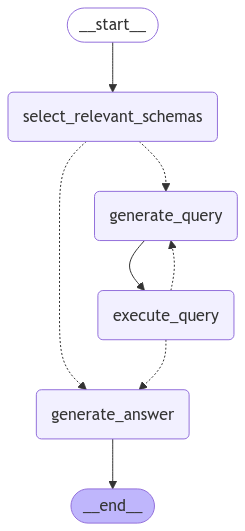

In [421]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [436]:
thread_1 = {"configurable": {"thread_id": "1"}}
question = "how many managers are present?"
response = graph.invoke({"question": question, "max_attempts": 5}, thread_1)
print(f"\n{response = }")

table_names ['employee']
[SystemMessage(content='\nYou are a SQL expert .You need to identify relevant tables from a SQL database to answer the user’s question.  \nAvailable tables: [\'employee\']  \nReturn a list of the relevant tables. If none are relevant, return an empty list.  \nOnly return the list—no explanations.\n\nExamples:  \nUser Question: "What are the total sales for the last month?"  \nAvailable Tables: ["users", "orders", "products", "inventory", "sales"]  \nResponse: ["sales"]  \n\nUser Question: "Show me the list of employees in the HR department."  \nAvailable Tables: ["users", "orders", "employees", "departments"]  \nResponse: ["employees", "departments"]  \n\nUser Question: "How many visitors accessed the website last week?"  \nAvailable Tables: ["users", "orders", "products"]  \nResponse: []  \n', additional_kwargs={}, response_metadata={}), HumanMessage(content='how many managers are present?', additional_kwargs={}, response_metadata={})]
relevant tables  ["emplo

In [435]:
print(response["answer"])

Sure, here are the names of all the employees, listed in the order of their most recent joining date:

1. Nate King
2. William Harris
3. Levi Jenkins
4. Charlie Davis
5. Charlotte Hall
6. Ava Martin
7. Daniel Gonzalez
8. Lucas King
9. Ivy Wilson
10. Olivia Perry
11. John Doe
12. Henry Mitchell
13. Liam Gray
14. Sofia Baker
15. Oliver Davis
16. Mia Lopez
17. Jane Smith
18. Jack Black
19. Emily Perez
20. Victoria Ramirez
21. Frank White
22. Eleanor Ross
23. Benjamin Lewis
24. Aiden Rivera
25. Amelia Foster
26. Alice Johnson
27. Grace Green
28. Ella Morgan
29. Karen Scott
30. Sophia Reed
31. Harper Wilson
32. Noah Adams
33. Matthew Powell
34. Hank Lee
35. Emma Turner
36. Scarlett Bennett
37. Larry Adams
38. James Ward
39. Grace Torres
40. Elijah Robinson
41. Ethan Scott
42. Bob Brown
43. Jackson Kelly
44. Ella Foster
45. Eve Martin
46. Abigail Carter
47. Isabella Clark
48. Avery Sanders
49. Chloe White
50. Mona Young

This list includes all the employees in the order of their most recent 